# ADALM2000: Analog IN OUT
- https://www.analog.com/en/design-center/evaluation-hardware-and-software/evaluation-boards-kits/adalm2000.html#eb-overview
- https://www.analog.com/en/technical-articles/how-to-create-an-oscilloscope-using-python-and-adalm2000.html
- https://analogdevicesinc.github.io/libm2k/annotated.html
- https://wiki.analog.com/university/tools/m2k/libm2k/libm2k#building_bindings
- https://github.com/analogdevicesinc/libm2k
- https://github.com/analogdevicesinc/libm2k/tree/master/bindings/python/examples
- https://wiki.analog.com/resources/fpga/docs/hdl/m2k
- https://www.analog.com/en/design-center/evaluation-hardware-and-software/evaluation-boards-kits/eval-adalp2000.html
- https://wiki.analog.com/university/courses/electronics

Divers
- https://www.embedded.com/using-python-to-simplify-noise-analysis-of-mixed-mode-signal-chains/

Installation der Kommunikationstreiber
1. https://github.com/analogdevicesinc/libm2k/releases/   => libm2k-x.y.z-Windows-setup.exe
2. pip install --upgrade -i https://test.pypi.org/simple/ libm2k

In [15]:
# Installation des Pythonmoduls für die Kommunikation zum ADALP2000
# import sys
# !{sys.executable} -m pip install --upgrade -i https://test.pypi.org/simple/ libm2k

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import libm2k
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import seaborn as sns
plt.style.use('dark_background')  # default https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.rcParams['figure.figsize'] = (8, 2)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 8
# plt.rcParams['font'] = {'size': 8}
# sns.set(rc={'figure.figsize':(5,5)})
# sns.color_palette('dark')  # https://seaborn.pydata.org/tutorial/color_palettes.html
# %matplotlib inline
# plt.rcParams.keys()

## Verdrahtung Messmittel
<img src="img/signaltest.jpg" width="300px" align="left"/>

In [37]:
# öffne die Schnittstelle zum ADALP2000
try:
    if ctx is not None:
        ctx = libm2k.m2kOpen()
        if ctx is None:
            print('Verbindungsfehler zum ADALM2000')
except:
    ctx = libm2k.m2kOpen()
    if ctx is None:
        print('Verbindungsfehler zum ADALM2000')

---
## DAC Analogausgang

Verfügbare Samplerates: (750.0, 7500.0, 75000.0, 750000.0, 7500000.0, 75000000.0)
f = 1000Hz | T = 0.001s | buffer_size = 75000 | sample_rate = 75000000sps


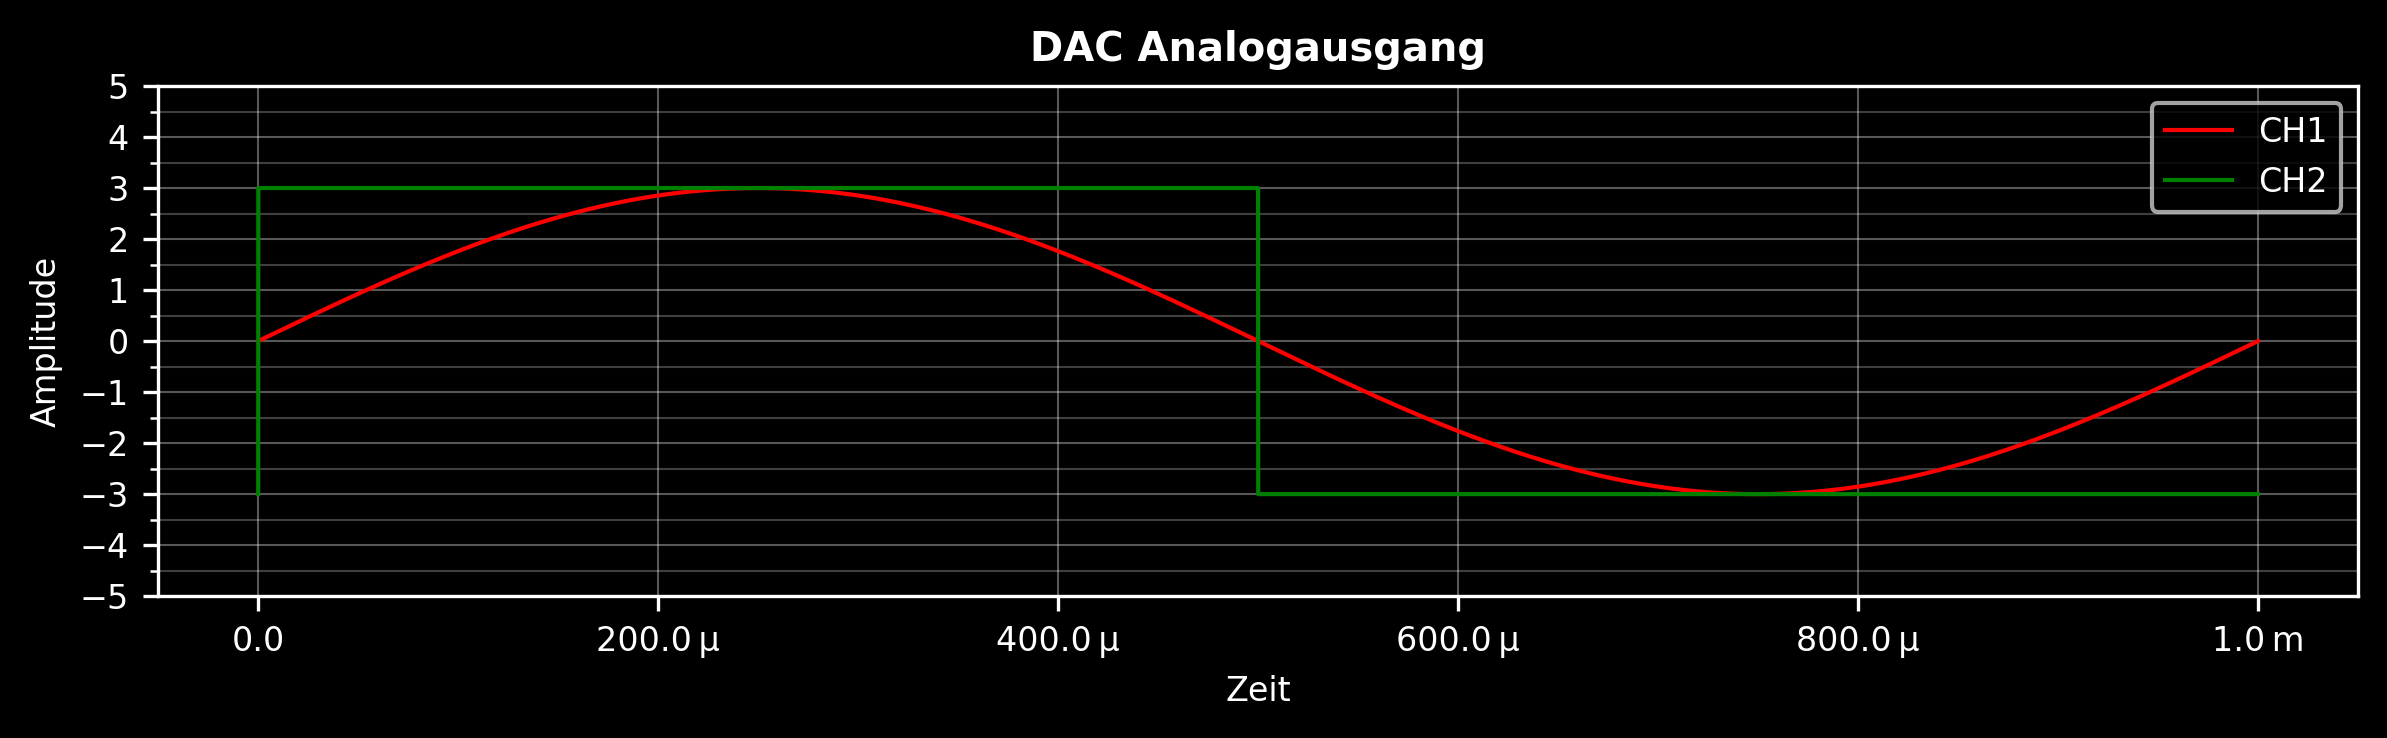

In [39]:
# kontinuirliche Ausgabe eines Signales bis die Schnittstelle wieder geschlossen wird
if ctx is not None:
    aout = ctx.getAnalogOut()
    aout.reset()
    ctx.calibrateDAC()
    aout.enableChannel(0, True)
    aout.enableChannel(1, True)
    # Systemvoraussetzung
    # https://analogdevicesinc.github.io/libm2k/group__analogout.html
    print(f'Verfügbare Samplerates: {aout.getAvailableSampleRates(0)}')
    
    f = 1.0 * 10**3
    T = 1 / f
    sample_rate = aout.getAvailableSampleRates(0)[5]
    buffer_size = int(sample_rate / f) 
    t = np.linspace(0.0, T, buffer_size)
    print(f'{f = :1.0f}Hz | {T = }s | {buffer_size = } | {sample_rate = :1.0f}sps')    
    aout.setSampleRate(0, sample_rate)
    aout.setSampleRate(1, sample_rate * 1.0)
    amplitude = 3
    signal_out_1 = np.sin(np.linspace(0, 2 * np.pi, buffer_size)) * amplitude
    signal_out_2 = (np.heaviside(np.sin(np.linspace(0, 2 * np.pi, buffer_size)), np.zeros(buffer_size)) - 0.5) * 2 * amplitude
    signal_out = [signal_out_1, signal_out_2]
    aout.setCyclic(True)  # kontinuirliche Signalausgabe
    aout.push(signal_out)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
    ax.plot(t, signal_out_1, lw=1, ls='-', marker='o', markersize=0, color='r', alpha=1.0, label='CH1')
    ax.plot(t, signal_out_2, lw=1, ls='-', marker='o', markersize=0, color='g', alpha=1.0, label='CH2')
    ax.xaxis.set_major_formatter(EngFormatter(places=1, sep="\N{THIN SPACE}"))
    ax.set_ylim([-5.0, 5.0])
    ax.set_yticks(np.linspace(-5, 5, 11))
    ax.set_yticks(np.linspace(-5, 5, 21), minor=True)
    ax.grid(which='major', color='w', alpha=0.35, ls='-', lw=0.5)  # both major minor
    ax.grid(which='minor', color='w', alpha=0.25, ls='-', lw=0.5)
    ax.set_title('DAC Analogausgang', fontweight='bold')
    ax.set_xlabel('Zeit')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='best')  # best, upper left, upper center, upper right, center .., lower ..
    fig.tight_layout()

---
## ADC Analogeingang

Verfügbare Samplerates: (1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0)
T = 0.002s | samples = 200000 | sample_rate = 100000000sps


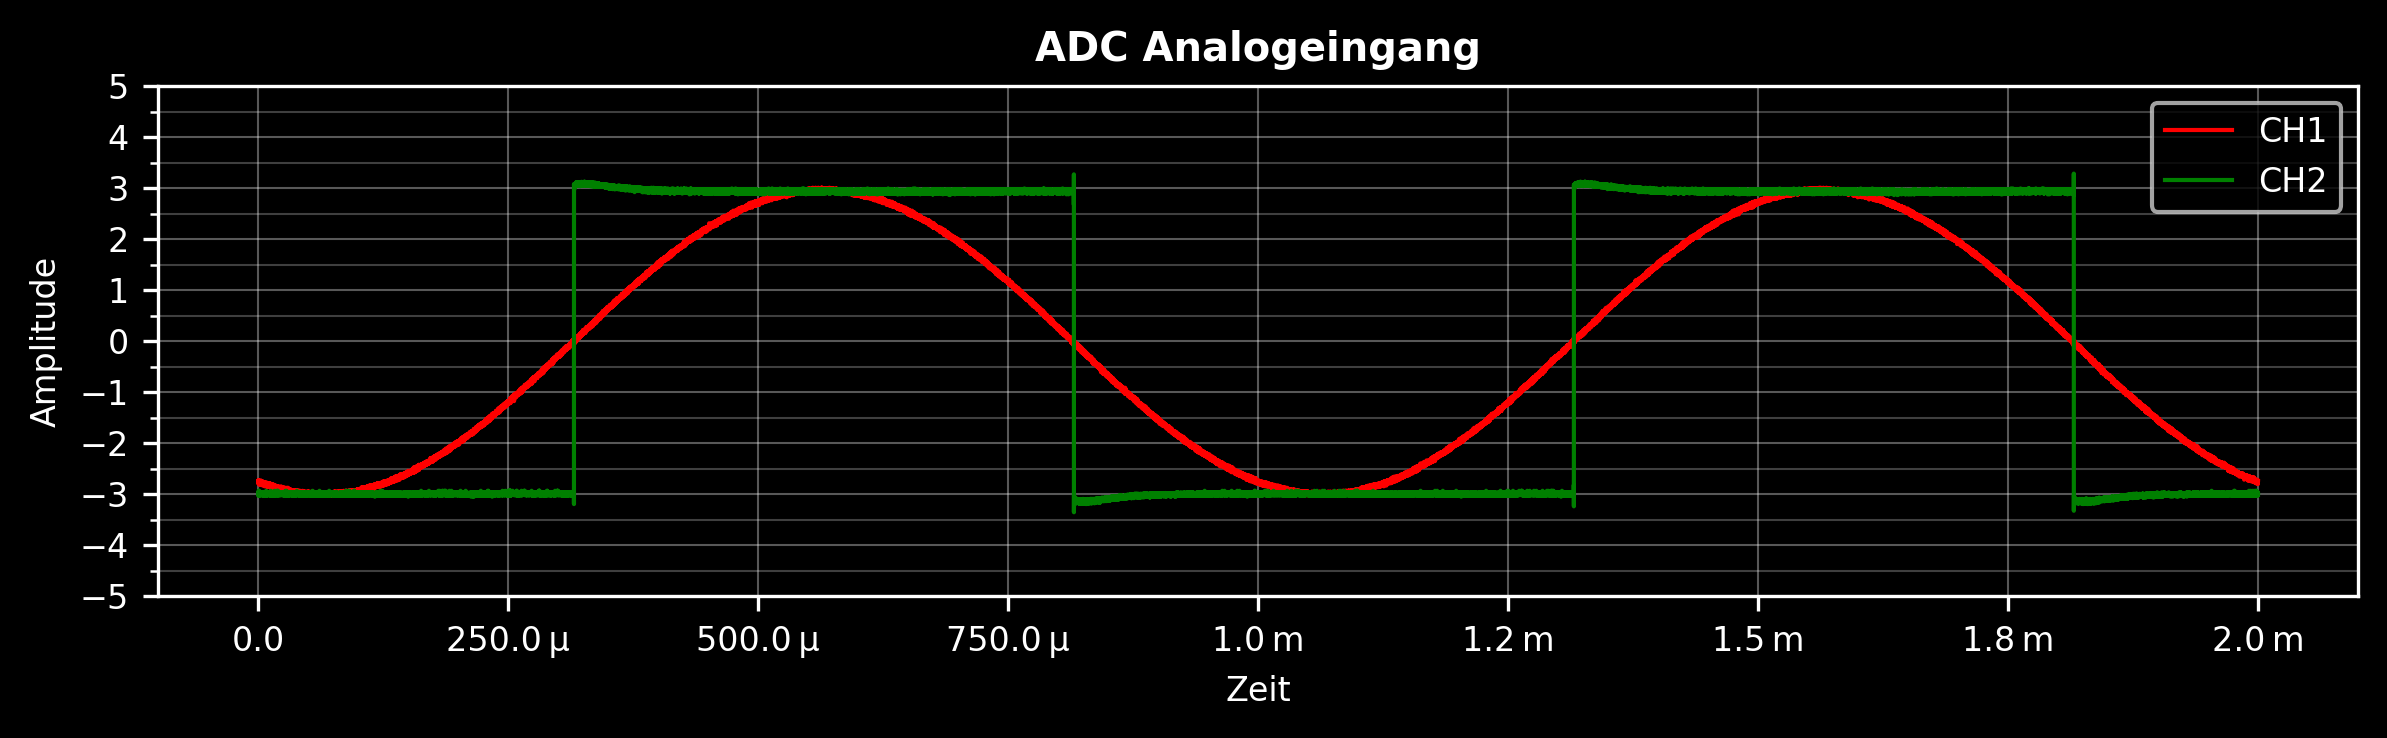

In [40]:
# kontinuirliche Ausgabe eines Signales bis die Schnittstelle wieder geschlossen wird
if ctx is not None:
    ain = ctx.getAnalogIn()
    ain.reset()
    ain.setRange(0, -5.0, 5.0)
    ctx.calibrateADC()
    ain.enableChannel(0, True)
    ain.enableChannel(1, True)
    # Systemvoraussetzung
    # https://analogdevicesinc.github.io/libm2k/group__analogin.html
    print(f'Verfügbare Samplerates: {ain.getAvailableSampleRates()}')
    
    # https://analogdevicesinc.github.io/libm2k/group__m2ktrigger.html
    trig = ain.getTrigger()
    trig.setAnalogSource(0) # Channel 0 as source
    trig.setAnalogCondition(0,libm2k.RISING_EDGE_ANALOG)
    trig.setAnalogLevel(0,0.5)  # Set trigger level at 0.5
    trig.setAnalogDelay(0) # Trigger is centered
    trig.setAnalogMode(1, libm2k.ANALOG)
    
    sample_rate = ain.getAvailableSampleRates()[5]
    T = 2 * 10**-3
    samples = int(sample_rate * T)
    t = np.linspace(0.0, T, samples)
    print(f'{T = }s | {samples = } | {sample_rate = :1.0f}sps')    
    
    ain.setSampleRate(sample_rate)
    [signal_in_1, signal_in_2] = ain.getSamples(samples)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
    ax.plot(t, signal_in_1, lw=1, ls='-', marker='o', markersize=0, color='r', alpha=1.0, label='CH1')
    ax.plot(t, signal_in_2, lw=1, ls='-', marker='o', markersize=0, color='g', alpha=1.0, label='CH2')
    ax.xaxis.set_major_formatter(EngFormatter(places=1, sep="\N{THIN SPACE}"))
    ax.set_ylim([-5.0, 5.0])
    ax.set_yticks(np.linspace(-5, 5, 11))
    ax.set_yticks(np.linspace(-5, 5, 21), minor=True)
    ax.grid(which='major', color='w', alpha=0.35, ls='-', lw=0.5)  # both major minor
    ax.grid(which='minor', color='w', alpha=0.25, ls='-', lw=0.5)
    ax.set_title('ADC Analogeingang', fontweight='bold')
    ax.set_xlabel('Zeit')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='best')  # best, upper left, upper center, upper right, center .., lower ..
    fig.tight_layout()

---

In [41]:
# schliesse den Kommunikationskanal zum ADALM2000
libm2k.contextClose(ctx)
del ctx

In [8]:
# END